In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataset import RigNetDataset, collate_fn, FILE_PATHS, POS_ATTN_AVG
from models import JointNet, JointDisplacementModule, VertexAttentionModule, GMEdgeConv, GMEdgeNet
from visualization_utils import visualize_mesh_graph, visualize_attention_heatmap
from training_utils import chamfer_loss, save_model

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
os.environ['DISPLAY']

'localhost:10.0'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def dict_to_device(d: dict, device: torch.device) -> dict:
    """
    Move all tensors (or lists of tensors) in d to the specified device.

    Args:
        d: A dict whose values may be torch.Tensor or list[torch.Tensor]
        device: e.g. "cpu" or "cuda"

    Returns:
        The same dict with all tensors relocated in-place.
    """
    for k, v in d.items():
        # single tensor
        if isinstance(v, torch.Tensor):
            d[k] = v.to(device)
        # list of tensors
        elif isinstance(v, list):
            new_list = []
            for item in v:
                if isinstance(item, torch.Tensor):
                    new_list.append(item.to(device))
                else:
                    new_list.append(item)
            d[k] = new_list
    return d


### Attention Module

In [5]:
dataset = RigNetDataset(FILE_PATHS['val'], num_samples=16, seed=42)
dl = DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [9]:
class SimpleAttentionModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = GMEdgeConv(3, 64)
        self.mlp = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, vertices, one_ring, geodesic):
        return self.mlp(self.conv(vertices, one_ring, geodesic))

In [10]:
simple_attn_module = SimpleAttentionModule()

In [11]:
POS_ATTN_AVG, (1 - POS_ATTN_AVG) / POS_ATTN_AVG

(0.2964, 2.3738191632928474)

In [12]:
attn_module = VertexAttentionModule()

In [13]:
epochs = 5000
lr = 5e-5
wd = 1e-6
optimizer = torch.optim.AdamW(attn_module.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-5,
    total_steps=epochs
)
pos_cls_weight = torch.tensor((1 - POS_ATTN_AVG) / POS_ATTN_AVG).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_cls_weight)

100%|██████████| 5000/5000 [18:56<00:00,  4.40it/s]


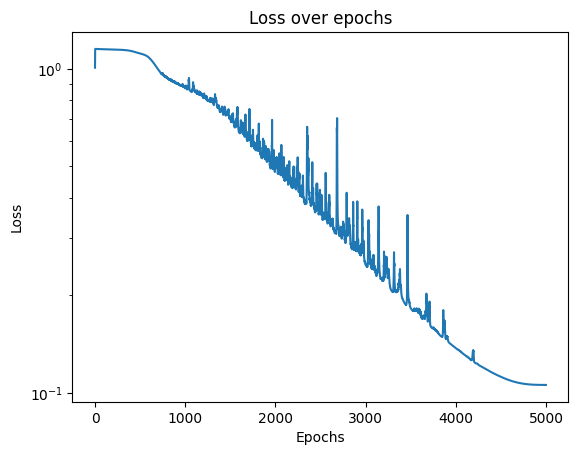

In [ ]:
loss_over_epochs = []

epoch_loss = 0.0
attn_module.to(device)
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    total_batches = 0
    for batch in dl:

        batch = dict_to_device(batch, device)
        batch_size = batch['vertices_per_graph'].size(0)

        logits = attn_module(
            batch['vertices'],
            batch['one_ring'],
            batch['geodesic']
        ).squeeze()

        assert logits.device.type == 'cuda'
        assert batch['attn_mask'].device.type == 'cuda'

        loss = criterion(logits, batch['attn_mask'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_batches += 1
    epoch_loss /= total_batches

    loss_over_epochs.append(epoch_loss)
    scheduler.step()
    # print(f"[Epoch {epoch}] loss={epoch_loss:.4f}")

In [ ]:
plt.figure()
plt.semilogy(loss_over_epochs)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
all_preds = []
all_gts = []

for batch in tqdm(dl, desc="Evaluating all batches"):
    attn_module.to(device)
    batch = dict_to_device(batch, device)

    # predict
    attn_pred_probs = F.sigmoid(attn_module(
        batch['vertices'],
        batch['one_ring'],
        batch['geodesic']
    ).squeeze())
    attn_preds = (attn_pred_probs >= 0.5).long().cpu().numpy()
    attn_gts = batch['attn_mask'].long().cpu().numpy()

    # accumulate
    all_preds.append(attn_preds)
    all_gts.append(attn_gts)

# flatten into big 1-D arrays
all_preds = np.concatenate(all_preds, axis=0)
all_gts = np.concatenate(all_gts, axis=0)

# compute your overall scores
acc = accuracy_score(all_gts, all_preds)
cm = confusion_matrix(all_gts, all_preds, labels=[0,1])
prf = precision_recall_fscore_support(all_gts, all_preds, labels=[0,1])

print("=== Overall Metrics ===")
print("Positive label: 0, Negative label: 1")
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Precision, Recall, F1, Support:\n", prf)

Evaluating all batches: 100%|██████████| 8/8 [00:00<00:00, 63.82it/s]

=== Overall Metrics ===
Positive label: 0, Negative label: 1
Accuracy: 0.9777
Confusion Matrix:
 [[19332   613]
 [   49  9736]]
Precision, Recall, F1, Support:
 (array([0.99747175, 0.94076722]), array([0.96926548, 0.99499234]), array([0.98316635, 0.96712029]), array([19945,  9785]))


In [19]:
save_model(
    state_dict=attn_module.state_dict(),
    file_path='models/attn_module.pt',
    timestamp=True
)

'models/attn_module_20250702-030900.pt'

Visualization, both live and headless, is being a pain on ssh. Just gonna export the models to my home machine.

### Displacement Head Only

In [20]:
dataset = RigNetDataset(FILE_PATHS['val'], num_samples=16, seed=42)
dl = DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [21]:
from training_utils import chamfer_loss

def batch_displacement_chamfer_loss(
    q_pred: torch.Tensor,
    joints_gt_list: list[torch.Tensor],
    vertices_per_graph: torch.Tensor,
    device: str = 'cpu'
):
    """
        Compute average Chamfer losses per graph:
        - L_disp: between displaced vertices q_b and ground-truth joints

        Args:
            q_pred: [Sum_N, 3] tensor of displaced vertices for all graphs
            joints_gt_list: list of length M, each [Ji, 3] tensor
            vertices_per_graph: 1D tensor of length M = number of vertices per graph
            device: "cpu" or "cuda"

        Returns:
            L_disp_avg: scalar tensor
        """
    
    # Build splits of the big batch back into graph‐specific vertex indices
    splits = torch.split(
        torch.arange(q_pred.size(0), device=device),
        vertices_per_graph.to(device).tolist()
    )

    disp_losses = []

    for idxs, joints_gt in zip(splits, joints_gt_list):
            # vertices for this graph
            q_b = q_pred[idxs] # [Ni, 3]
            # ensure gt is on the right device
            joints_gt = joints_gt.to(device) # [Ji, 3]

            # Chamfer between displaced vertices and true joints
            Ld = chamfer_loss(q_b, joints_gt)
            disp_losses.append(Ld)
    
    # average across graphs
    L_disp_avg = torch.stack(disp_losses).mean()
    return L_disp_avg

In [22]:
disp_model = JointDisplacementModule()

In [ ]:
# disp head
epochs = 1000
lr=5e-5
wd = 1e-6
optimizer = torch.optim.AdamW(disp_model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-5,
    total_steps=epochs
)

Epochs: 100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


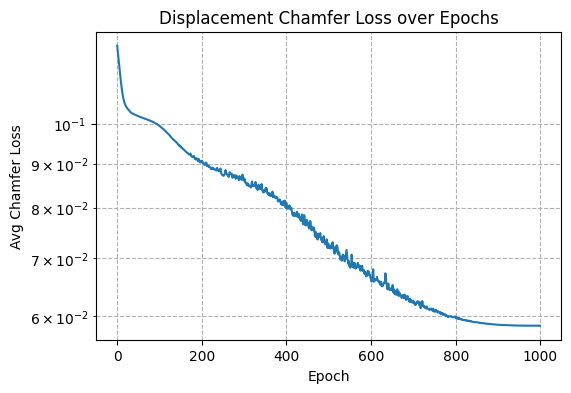

In [ ]:
loss_over_epochs = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    disp_model.to(device)
    disp_model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in dl:
        # move to device
        batch = dict_to_device(batch, device)

        # predict displacements
        disp = disp_model(
            batch['vertices'],
            batch['one_ring'],
            batch['geodesic']
        )
        q_pred = batch['vertices'] + disp

        # compute loss against GT joints
        loss = batch_displacement_chamfer_loss(
            q_pred,
            batch['joints_list'],
            batch['vertices_per_graph'],
            device=device
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    # end of epoch
    avg_loss = running_loss / n_batches
    loss_over_epochs.append(avg_loss)
    scheduler.step()

In [ ]:
# --- plot ---
plt.figure(figsize=(6,4))
plt.semilogy(loss_over_epochs)
plt.title("Displacement Chamfer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Avg Chamfer Loss")
plt.grid(True, which="both", ls="--")
plt.show()

In [25]:
save_model(
    state_dict=disp_model.state_dict(),
    file_path='models/disp_module.pt',
    timestamp=True
)

'models/disp_module_20250702-031409.pt'

### Full Model

Two losses: chamfer loss between joints_gt and both q_pred and joints_pred
- L_disp (q_pred) only affects displacement module parameters. 
- L_disp + L_joint affects all params

q_pred needs to be unbatched. joints_pred and joints_gt are already lists of tensors.
Then we loop over each graph and calculate the batch avg. loss and perform backprop.

In [5]:
dataset = RigNetDataset(
    FILE_PATHS['val'], 
    num_samples=16, 
    seed=42
)

dl = DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
def batch_rignet_loss(
    q_pred_list: torch.Tensor,
    joints_pred_list: list[torch.Tensor],
    joints_gt_list: list[torch.Tensor],
    device: str = 'cpu'
):
    """
        Compute average Chamfer losses per graph:
        - L_disp: between displaced vertices q_b and ground-truth joints
        - L_joint: between clustered joint preds and ground-truth joints

        Args:
            q_pred_list: list of  length M, each [Sum_N, 3] tensor
            joints_pred_list: list of length M, each [Ki, 3] tensor
            joints_gt_list: list of length M, each [Ji, 3] tensor
            vertices_per_graph: 1D tensor of length M = number of vertices per graph
            device: "cpu" or "cuda"

        Returns:
            (L_disp_avg, L_joint_avg): two scalar tensors
        """

    disp_losses = []
    joint_losses = []

    for q, joints_pred, joints_gt in zip(q_pred_list, joints_pred_list, joints_gt_list):

            # ensure gt is on the right device
            q = q.to(device)
            joints_pred = joints_pred.to(device)  # [Ki, 3]
            joints_gt = joints_gt.to(device) # [Ji, 3]

            # Chamfer between displaced vertices and true joints
            Ld = chamfer_loss(q, joints_gt)
            # Chamfer between clustered joints and true joints
            Lj = chamfer_loss(joints_pred, joints_gt)

            disp_losses.append(Ld)
            joint_losses.append(Lj)
    
    # average across graphs
    L_disp_avg  = torch.stack(disp_losses).mean()
    L_joint_avg = torch.stack(joint_losses).mean()
    return L_disp_avg, L_joint_avg

In [7]:
model = JointNet()
pretrain_attn_model_path = 'models/attn_module_20250702-030900.pt'
model.attn_head.load_state_dict(torch.load(pretrain_attn_model_path))

<All keys matched successfully>

In [8]:
epochs = 1000
lr=5e-5
wd = 1e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-5,
    total_steps=epochs
)
pos_cls_weight = torch.tensor((1 - POS_ATTN_AVG) / POS_ATTN_AVG).to(device)
attn_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_cls_weight)

In [11]:
total_loss_hist, disp_loss_hist, joint_loss_hist, attn_loss_hist = [], [], [], []


for epoch in tqdm(range(epochs), desc='Epochs'):
    model.train()
    running_total = running_disp = running_joint = running_attn = 0.0
    n_batches = 0

    for batch in dl:
        # 1) move batch to device
        model.to(device)
        batch = dict_to_device(batch, device)

        # 2) forward pass: get per-graph q, attn logits, joints_pred
        q_list, attn_list, joints_pred_list = model(batch)

        # 3) compute displacement & joint losses
        L_disp, L_joint = batch_rignet_loss(
            q_list,
            joints_pred_list,
            batch['joints_list'],
            device=device
        )
        loss = L_disp + L_joint

        # 4) backward + step for disp+joint heads
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 5) compute attention loss just for logging
        #    flatten all attn logits and masks
        attn_logits = torch.cat(attn_list).view(-1).to(device)
        attn_targets = batch['attn_mask'].float().to(device)
        L_attn = attn_criterion(attn_logits, attn_targets)

        # 6) accumulate stats
        running_total += loss.item()
        running_disp += L_disp.item()
        running_joint += L_joint.item()
        running_attn += L_attn.item()
        n_batches += 1

    # end of epoch: compute averages
    avg_total = running_total / n_batches
    avg_disp = running_disp  / n_batches
    avg_joint = running_joint / n_batches
    avg_attn = running_attn  / n_batches

    total_loss_hist.append(avg_total)
    disp_loss_hist.append(avg_disp)
    joint_loss_hist.append(avg_joint)
    attn_loss_hist.append(avg_attn)

    # print(
    #     f"[Epoch {epoch}] "
    #     f"total={avg_total:.4e}, "
    #     f"disp={avg_disp:.4e}, "
    #     f"joint={avg_joint:.4e}, "
    #     f"attn={avg_attn:.4e}"
    # )

    scheduler.step()

Epochs: 100%|██████████| 1000/1000 [11:12<00:00,  1.49it/s]


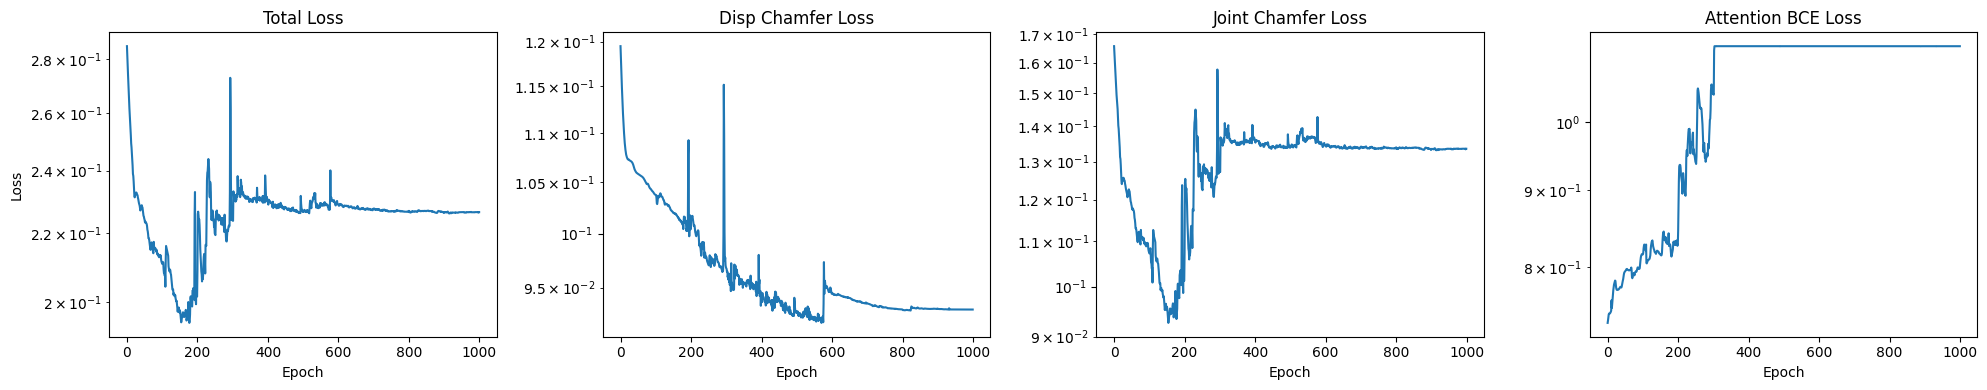

In [13]:
# --- Plot all four curves side by side ---
epochs_range = range(epochs)
fig, axes = plt.subplots(ncols=4, figsize=(20,4), tight_layout=True)

# Total loss
axes[0].semilogy(epochs_range, total_loss_hist)
axes[0].set_title("Total Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Displacement loss
axes[1].semilogy(epochs_range, disp_loss_hist)
axes[1].set_title("Disp Chamfer Loss")
axes[1].set_xlabel("Epoch")

# Joint prediction loss
axes[2].semilogy(epochs_range, joint_loss_hist)
axes[2].set_title("Joint Chamfer Loss")
axes[2].set_xlabel("Epoch")

# Attention loss
axes[3].semilogy(epochs_range, attn_loss_hist)
axes[3].set_title("Attention BCE Loss")
axes[3].set_xlabel("Epoch")

plt.show()

In [14]:
model.clustering_head.h

Parameter containing:
tensor(0.0518, device='cuda:0', requires_grad=True)

In [15]:
save_model(
    state_dict=model.state_dict(),
    file_path='models/jointnet.pt',
    timestamp=True
)

'models/jointnet_20250702-110226.pt'